# Análisis con K-Means – Kmeans Segmentacion Clientes

**Contexto:** Una empresa retail desea segmentar a sus clientes usando variables como frecuencia de compra, monto promedio y edad, con el fin de diseñar campañas de marketing más efectivas.

**Objetivo:** Aplicar K-Means para descubrir grupos homogéneos de clientes y personalizar estrategias comerciales.

## Paso 1: Importar librerías necesarias
**Descripción:** Se importan las librerías que se utilizarán para manipular datos, crear el modelo K-Means, escalar variables, reducir dimensiones y graficar.

**Conclusión:** Con estas herramientas se puede realizar un análisis completo de clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## Paso 2: Cargar el dataset
**Descripción:** Se carga el archivo CSV y se visualizan las primeras filas para conocer la estructura del dataset.

**Conclusión:** Se identifican las variables que serán utilizadas para el análisis de clustering.

In [2]:
df = pd.read_csv('segmentacion_clientes.csv')
df.head()

,cliente_id,frecuencia_compra,monto_promedio,num_productos,edad,ciudad
0,2ff261eb-6219-4848-ad1e-dad0d334bf56,9,212.71,11,19,Sherrytown
1,d3fa6478-4582-4735-9036-add5a0a1211b,6,140.03,3,51,South Rachel
2,5c385803-25b0-4f3d-9d54-eae57087632c,7,159.84,15,22,Frankland
3,0122fb58-c2bd-4044-beb3-476090411c6a,9,121.74,18,69,Lake Kimberly
4,f7734fa5-40cd-41cc-b6e8-21f1661e98c5,9,79.28,2,66,South Christophermouth


## Paso 3: Seleccionar variables numéricas y escalar los datos
**Descripción:** Se seleccionan las columnas numéricas y se estandarizan para que todas tengan igual peso en la distancia.

**Conclusión:** Se garantiza que ninguna variable domine el cálculo de distancias debido a su escala.

In [3]:
data = df.select_dtypes(include=['int64', 'float64'])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

## Paso 4: Método del Codo para determinar el número óptimo de clusters
**Descripción:** Se calcula la inercia para distintos valores de K y se grafica para identificar el punto de quiebre ('codo').

**Conclusión:** El punto donde la curva deja de descender abruptamente sugiere el número óptimo de clusters.

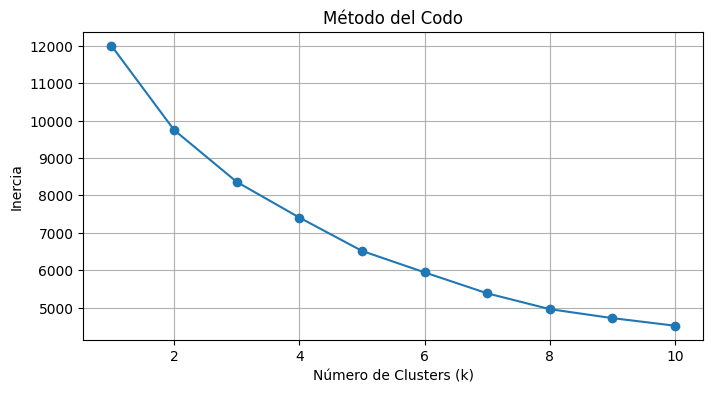

In [4]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

## Paso 5: Aplicar K-Means con K óptimo
**Descripción:** Se ejecuta el algoritmo K-Means con el número de clusters elegido.

**Conclusión:** Cada punto queda asignado a uno de los clusters creados.

In [5]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_scaled)
df['cluster'] = kmeans.labels_

## Paso 6: Visualización de clusters (2D con Pairplot)
**Descripción:** Se visualizan las relaciones entre variables coloreando por cluster.

**Conclusión:** Se observa si los clusters tienen separación visual clara en 2D.

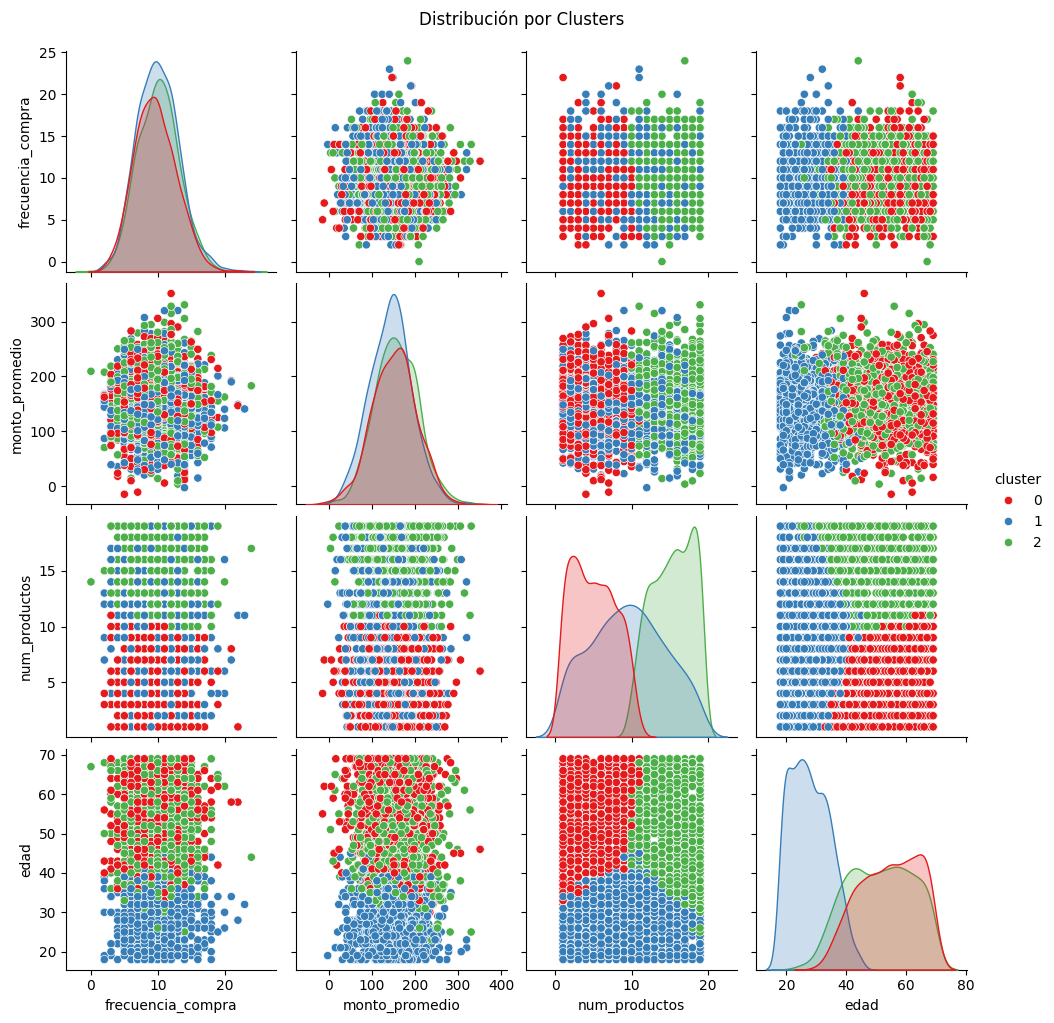

In [6]:
sns.pairplot(df, hue='cluster', palette='Set1')
plt.suptitle('Distribución por Clusters', y=1.02)
plt.show()

## Paso 7: Silhouette Score y gráfico de silueta
**Descripción:** Se calcula el coeficiente de silueta global y por punto para evaluar la calidad de los clusters.

**Conclusión:** Valores cercanos a 1 indican buena asignación. Se visualiza la cohesión interna de cada grupo.

Silhouette Score: 0.1797


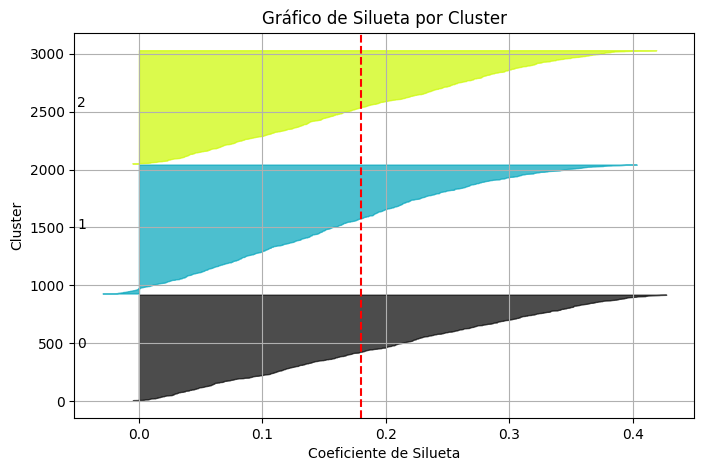

In [7]:
score = silhouette_score(data_scaled, kmeans.labels_)
print(f"Silhouette Score: {score:.4f}")

sample_silhouette_values = silhouette_samples(data_scaled, kmeans.labels_)
y_lower = 10
fig, ax1 = plt.subplots(figsize=(8, 5))

for i in range(k):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title('Gráfico de Silueta por Cluster')
ax1.set_xlabel('Coeficiente de Silueta')
ax1.set_ylabel('Cluster')
ax1.axvline(x=score, color="red", linestyle="--")
plt.grid(True)
plt.show()

📐 Silhouette Score = 0.1797
📌 ¿Qué mide?
Evalúa qué tan bien se encuentra un punto dentro de su propio cluster comparado con otros clusters.

Se basa en:

Cohesión: qué tan cerca está un punto de los demás en su mismo grupo.

Separación: qué tan lejos está de puntos de otros grupos.

🧮 Rango de valores:
Va de -1 a 1:

Valor	Interpretación
Cerca de 1	Clusters bien definidos y separados
~ 0.5 - 0.7	Agrupamiento razonablemente bueno
~ 0.2 - 0.4	Estructura débil, pero posiblemente válida
< 0.2	Clusters se solapan o mal definidos
< 0	Mala asignación (punto en el cluster equivocado)

🎯 Interpretación de tu valor:
0.1797 indica un agrupamiento débil.

Sugiere que:

Algunos puntos están cerca del borde entre clusters.

Puede haber solapamiento entre grupos.

La estructura de los clusters no es muy clara.

## Paso 8: Métricas Davies-Bouldin y Calinski-Harabasz
**Descripción:** Métricas complementarias que evalúan la compacidad y separación entre clusters.

**Conclusión:** Se usan para confirmar la calidad del agrupamiento.

In [8]:
db_score = davies_bouldin_score(data_scaled, kmeans.labels_)
ch_score = calinski_harabasz_score(data_scaled, kmeans.labels_)
print(f"Davies-Bouldin Score: {db_score:.4f}")
print(f"Calinski-Harabasz Score: {ch_score:.2f}")

Davies-Bouldin Score: 1.6477
Calinski-Harabasz Score: 652.65


📏 1. Davies-Bouldin Score (DB) = 1.6477
📌 ¿Qué mide?
Mide la similitud entre los clusters, evaluando qué tan cercanos están los grupos entre sí en relación con su dispersión interna.

🎯 Interpretación:
Cuanto más bajo el valor, mejor. Un valor más bajo indica:

Mayor separación entre clusters.

Menor solapamiento.

Grupos más compactos.

✅ Evaluación de tu resultado:
Un valor de 1.6477 es moderadamente aceptable.

Idealmente, valores por debajo de 1.5 se consideran buenos.

Puede sugerir que hay cierto solapamiento entre grupos o clusters poco definidos, aunque no es alarmante.

📊 2. Calinski-Harabasz Score (CH) = 652.65
📌 ¿Qué mide?
Mide la proporción de la dispersión entre clusters frente a la dispersión dentro de los clusters.

🎯 Interpretación:
Cuanto más alto, mejor. Un valor alto indica:

Buena separación entre clusters.

Buena cohesión dentro de cada grupo.

✅ Evaluación de tu resultado:
Un valor de 652.65 es bastante bueno, especialmente en conjuntos de datos de tamaño mediano.

Sugiere que los grupos formados están bien definidos y separados.

## Paso 9: Visualización 2D con PCA
**Descripción:** Se reduce la dimensionalidad a 2 componentes principales para graficar los clusters y sus centroides.

**Conclusión:** Una separación clara refuerza la efectividad del modelo.

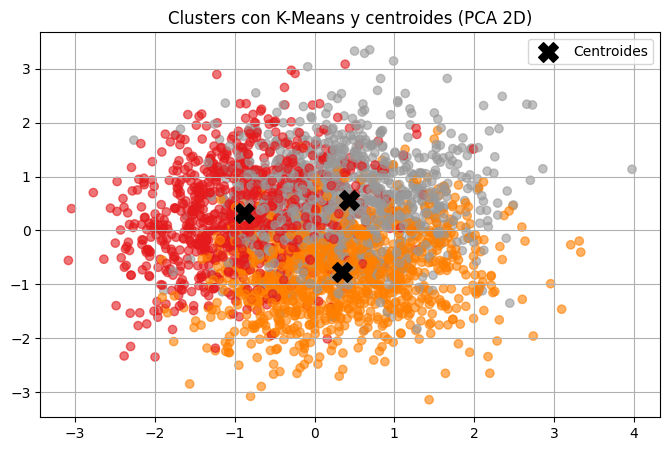

In [9]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 5))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='Set1', alpha=0.6)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='X', s=200, c='black', label='Centroides')
plt.title("Clusters con K-Means y centroides (PCA 2D)")
plt.legend()
plt.grid(True)
plt.show()

## Paso 10: Visualización 3D
**Descripción:** Se muestra una representación tridimensional de los clusters si existen al menos 3 variables numéricas.

**Conclusión:** Permite observar patrones más complejos entre los grupos.

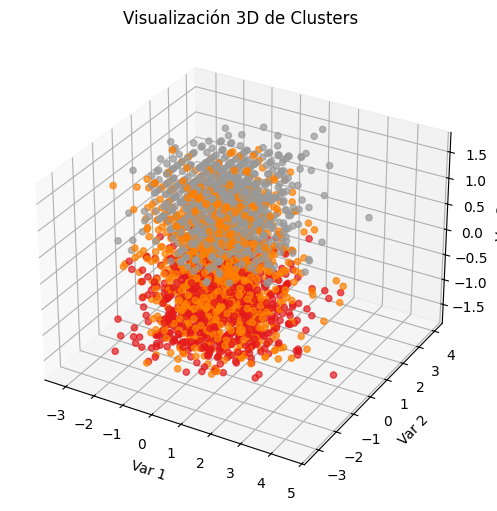

In [10]:
if data_scaled.shape[1] >= 3:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data_scaled[:, 0], data_scaled[:, 1], data_scaled[:, 2],
                         c=kmeans.labels_, cmap='Set1', alpha=0.7)
    ax.set_title("Visualización 3D de Clusters")
    ax.set_xlabel("Var 1")
    ax.set_ylabel("Var 2")
    ax.set_zlabel("Var 3")
    plt.show()
else:
    print("No hay suficientes variables numéricas para graficar en 3D.")

## ✅ Conclusiones Finales del Análisis con K-Means

- K-Means permite segmentar los datos de manera efectiva sin necesidad de etiquetas.
- Las métricas (Inercia, Silhouette, Davies-Bouldin, Calinski-Harabasz) ayudan a validar el número y calidad de clusters.
- Las visualizaciones 2D y 3D permiten una interpretación intuitiva de los grupos formados.
- Este tipo de análisis es aplicable en marketing, ciberseguridad, logística, entre otros.